# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [7]:
%load_ext autoreload
%autoreload 2

from unityagents import UnityEnvironment
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from collections import deque
import random
import torch.optim as optim
from torchsummary import summary
import matplotlib.pyplot as plt
from itertools import accumulate
from operator import itemgetter

import env_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name="Reacher.app", no_graphics=False)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [8]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [9]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [9]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.12099999729543924


### 4. Choose a learning Algorithm

For [Project 1: Navigation](https://github.com/mleonardallen/nd893-p1-navigation), I leveraged the [DQN Algorithm](https://arxiv.org/abs/1312.5602).

> We present the first deep learning model to successfully learn control policies directly from high-dimensional sensory input using reinforcement learning. The model is a convolutional neural network, trained with a variant of Q-learning, whose input is raw pixels and whose output is a value function estimating future rewards. We apply our method to seven Atari 2600 games from the Arcade Learning Environment, with no adjustment of the architecture or learning algorithm. We find that it outperforms all previous approaches on six of the games and surpasses a human expert on three of them.

DQN is a value based approach, seeking the optimal `action-value` function.  Performing an action with value based approaches involves an `argmax` operation to find the action with the highest value.  However, the `Reacher` environment has a `continuous action space`, and value based approaches are not suited to continuous action spaces because of this argmax operation.

We could potentially discretize the action space, but I don't think this will be effective.  Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector must be a number between -1 and 1.  Even with a small amount of granularity in torque values produces a large number of possible actions.

| Torque Values | Actions |
| -- | -- |
| -1.0, -0.5, 0.0, 0.5, 1.0 | 625 |
| -1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0 | 6,561 |

Because of the limitations of values based methods for continues action spaces, I think we need to use a policy based approach for the Reacher environment.  Policy based approaches seek to estimate the optimal policy directly, and therefore we don't run into this argmax issue that we have with value based approaches.

To begin, I'm going to keep it very simple using the [REINFORCE Algorithm](https://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.129.8871).  REINFORCE shows us how to adjust parameters so that good actions are more probable and bad actions are less probable.  Likely, this algorithm will do poorly with this environment, but we can see the results and add improvements as we go. The REINFORCE algorithm is summarized below.

1. Use the policy $\pi_\theta$ to collect $m$ trajectories {$\tau^{(1)},\tau^{(2)},\dots,\tau^{(m)}$} with horizon $H$.  We refer to the $i$-th trajectory as 

    $\tau^{(i)} = (s^{(i)}_0, a^{(i)}_0,\dots,s^{(i)}_H, a^{(i)}_H,s^{(i)}_{H+1})$


2. Use the trajectories to estimate the gradient $\nabla_\theta U(\theta)$:

    $\nabla_\theta U(\theta) \approx \hat{g} := \frac1m\sum_{i=1}^m\sum_{t=0}^H\nabla_\theta log\pi_\theta(a_t^{(i)}|s_t^{(i)}R(\tau^{(i)})$


3. Update the weights of the policy:

    $\theta \leftarrow \theta + \alpha\hat{g}$


4. Loop over steps 1-3

### 5. Replace the Random Actions with Random Actions 🙃

<img align="right" alt="tanh" title="tanh" src="img/tanh.png" width="250"/>

Since this is my first project involving continuous actions spaces, I want to build the project step by step, until I have an agent that can efficiently learn and solve the environment.

First, I just want to replace the random actions produced by `np.random.randn` with a neural network that outputs random actions.  The actions are random because the network is untrained.  Theoretically though, the trained network could produce optimal actions.

Note: The output layer uses [tanh](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh) to produce the desired torque application values (-1, 1).

In [10]:
class Network(nn.Module):

    def __init__(self, input_size, output_size, hidden_layers):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        self.layers.extend([nn.Linear(i, o) for i, o in zip(hidden_layers[:-1], hidden_layers[1:])])
        self.output = nn.Linear(hidden_layers[-1], output_size)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.elu(layer(x))
        return torch.tanh(self.output(x))

policy = Network(state_size, action_size, [64, 64])
summary(policy, (1, state_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]           2,176
            Linear-2                [-1, 1, 64]           4,160
            Linear-3                 [-1, 1, 4]             260
Total params: 6,596
Trainable params: 6,596
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [11]:
env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
scores = np.zeros(num_agents)

while True:
    actions = policy(torch.from_numpy(states).float()).detach().numpy() # actions come from network
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    scores += env_info.rewards
    states = next_states
    if np.any(dones):
        break

print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.4599999897181988


<img src="img/random.gif" />

The 20 agent environment is a bit overwhelming visually, but we can see that the agent behavior is quite random, and we can tell agent is not doing that well.  Bright green indicates the  agent's hand is in the goal location.

### 6. Update the Network to work with REINFORCE

<img align="right" alt="tanh" title="tanh" src="img/softplus.png" width="250"/>

REINFORCE shows us how to adjust parameters so that good actions are more probable and bad actions are less probable.  To achieve this, the network needs to output probabilities, and currently the network only outputs actions.

I make a small tweak to the network so that it returns the action AND probabiliy of taking that action.  The original output becomes the `mean` and I use that mean to create a `normal distribution`.

Note: When creating the normal distribution I use a [softplus](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) operation.  This is because standard deviations cannot be negative.

In [10]:
class Network(nn.Module):

    def __init__(self, input_size, output_size, hidden_layers):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        self.layers.extend([nn.Linear(i, o) for i, o in zip(hidden_layers[:-1], hidden_layers[1:])])
        self.output = nn.Linear(hidden_layers[-1], output_size)
        self.std = nn.Parameter(torch.zeros(output_size)) # parameter for standard deviation
    
    def forward(self, x, action=None):
        for i, layer in enumerate(self.layers):
            x = F.elu(layer(x))
        mean = torch.tanh(self.output(x)) # original output becomes mean of distribution
        dist = torch.distributions.Normal(mean, F.softplus(self.std)) # create distribution with mean, std
        if action is None:
            action = dist.sample() # action sampled from distribution
        log_prob = dist.log_prob(action) # probabilities required for REINFORCE
        entropy = dist.entropy()
        return {'mean': mean, 'action': action, 'log_prob': log_prob, 'entropy': entropy}

policy = Network(state_size, action_size, [64, 64])
summary(policy, (1, state_size)) # summary is not including std ¯\_(ツ)_/¯

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]           2,176
            Linear-2                [-1, 1, 64]           4,160
            Linear-3                 [-1, 1, 4]             260
Total params: 6,596
Trainable params: 6,596
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


### 7. Build the REINFORCE Agent

I impliment the REINFORCE algorithm below.  For the Reacher environment, I do not think REINFORCE can learn a decent policy, but let's check it out and see how it performs.

Note: At this point, I extracted out main loop into a `env_utils` file because I just want to focus on the details of the algorithm here.

In [13]:
class Agent():
    
    def __init__(self, config):
        self.config = config
        self.policy = Network(state_size, action_size, [64, 64])
        self.optimizer = optim.Adam(self.policy.parameters(), lr=5e-4)
        self.storage = []
    
    def act(self, states):
        return self.policy(torch.from_numpy(states).float())
    
    def step(self, states, actions, rewards, next_states, dones):
        
        self.storage.append((actions['log_prob'], rewards))
        if np.any(dones):
            self.learn()
            
    def learn(self):
        log_probs, rewards = zip(*self.storage)
        log_probs = torch.stack(log_probs)

        """ Sum Rewards
        Pretend Example: 4 agents, each with a trajectory over 3 time steps
        
            axis=0
              ↓ 
            [[1, 0, 0, 0], t=0
             [1, 0, 1, 0], t=1
             [1, 0, 1, 1]] t=2
             ------------
        sum: [3, 0, 2, 1]
        
        """
        R = np.sum(rewards, axis=0)[:,np.newaxis]
        R = torch.from_numpy(R).float()

        policy_loss = torch.mean(-log_probs * R) # negative because optimizer uses gradient descent

        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

        self.storage = []

Episode: 25, Total score (averaged over agents): 1.1199999749660492
Episode: 50, Total score (averaged over agents): 1.3569999696686863
Episode: 75, Total score (averaged over agents): 1.1334999746643006
Episode: 100, Total score (averaged over agents): 1.2654999717138709
Episode: 125, Total score (averaged over agents): 1.3549999697133899
Episode: 150, Total score (averaged over agents): 1.398499968741089
Episode: 175, Total score (averaged over agents): 1.1274999747984111
Episode: 200, Total score (averaged over agents): 1.23149997247383
Episode: 225, Total score (averaged over agents): 1.0889999756589532
Episode: 250, Total score (averaged over agents): 1.3504999698139728
Episode: 275, Total score (averaged over agents): 1.4299999680370092
Episode: 300, Total score (averaged over agents): 1.069499976094812
Episode: 325, Total score (averaged over agents): 1.192499973345548
Episode: 350, Total score (averaged over agents): 0.99899997767061
Episode: 375, Total score (averaged over age

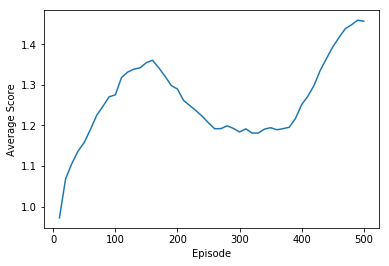

In [14]:
config = {}
config['env'] = env
config['print_every'] = 25
config['plot_every'] = 10
config['episodes'] = 500
agent = Agent(config)
env_utils.run(agent)
torch.save(agent.policy.state_dict(), 'checkpoints/REINFORCE-1.pth')

In [8]:
config = {}
config['env'] = env
config['train_mode'] = False
agent = Agent(config)
checkpoint = torch.load('checkpoints/REINFORCE-1.pth')
agent.policy.load_state_dict(checkpoint)
env_utils.run(agent)

<img src="img/REINFORCE-1.gif" />

Updates appear to be very noisy, and the average reward is very low even after training for 500 episides. When I watch the agent, it's clear that agent is barely doing better than taking random actions.

### 8. REINFORCE Improvements

What are the main problems of REINFORCE? There are three issues:

1. The update process is very inefficient! We run the policy once, update once, and then throw away the trajectory.

2. The gradient estimate $\hat{g}$ is very noisy. By chance the collected trajectory may not be representative of the policy.

3. There is no clear credit assignment. A trajectory may contain many good/bad actions and whether these actions are reinforced depends only on the final total output.

In [15]:
class Agent():
    
    def __init__(self, config):
        self.config = config
        self.gamma = 0.99
        self.beta = 0.01 # entropy regularization
        self.beta_decay = 0.995
        self.policy = Network(state_size, action_size, [64, 64])
        self.optimizer = optim.Adam(self.policy.parameters(), lr=5e-4)
        self.storage = []
        
    def act(self, states):
        return self.policy(torch.from_numpy(states).float())
    
    def step(self, states, actions, rewards, next_states, dones):
        self.storage.append((actions['log_prob'], actions['entropy'], rewards))
        if np.any(dones):
            self.learn()

    def learn(self):
        log_probs, entropy, rewards = zip(*self.storage)
        log_probs = torch.stack(log_probs)
        entropy = torch.stack(entropy)

        """ Clear Credit Assignment: Discounted Future Rewards
        Note: arr[::-1] is just syntax to reverse an array.
        Calculating the discounted future reward is easier starting at the end.
        """
        accumulate_fn = lambda acc,r: r+self.gamma*np.asarray(acc)
        R = np.array(list(accumulate(rewards[::-1], accumulate_fn)))[::-1]
        
        """ Less Noisy: Normalize Rewards
        Batch normalization is a technique for improving the speed, performance, and stability of a network.
        https://en.wikipedia.org/wiki/Batch_normalization

        Before normalizing, rewards were all positive for the Reacher environment.
        The normalized distribution, with μ = 0, produces both positive and negative rewards.
        Perhaps this lack of negative reward made it difficult to decrease probabilities of bad actions.
        """
        R = (R - np.mean(R))/np.std(R)
        R = torch.from_numpy(R.copy()).float().unsqueeze(2)

        """ Entropy Regularization to Encourage Exploration
        On-policy Reinforcement Learning with Entropy Regularization
        https://arxiv.org/abs/1912.01557
        """
        policy_loss = torch.mean(-log_probs * R - self.beta * entropy)

        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()
        
        self.beta *= self.beta_decay
        self.storage = []

Episode: 25, Total score (averaged over agents): 1.6944999621249734
Episode: 50, Total score (averaged over agents): 2.187499951105565
Episode: 75, Total score (averaged over agents): 2.3834999467246236
Episode: 100, Total score (averaged over agents): 3.497499921824783
Episode: 125, Total score (averaged over agents): 3.861999913677573
Episode: 150, Total score (averaged over agents): 3.945499911811203
Episode: 175, Total score (averaged over agents): 4.359999902546406
Episode: 200, Total score (averaged over agents): 5.460499877948314
Episode: 225, Total score (averaged over agents): 5.594999874942005
Episode: 250, Total score (averaged over agents): 7.093999841436744
Episode: 275, Total score (averaged over agents): 6.34999985806644
Episode: 300, Total score (averaged over agents): 7.918499823007733
Episode: 325, Total score (averaged over agents): 7.9799998216331005
Episode: 350, Total score (averaged over agents): 8.39149981243536
Episode: 375, Total score (averaged over agents): 

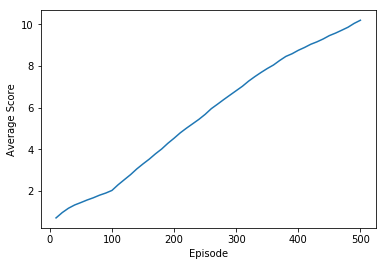

In [16]:
config = {}
config['env'] = env
config['print_every'] = 25
config['plot_every'] = 10
config['episodes'] = 500
agent = Agent(config)
env_utils.run(agent)
torch.save(agent.policy.state_dict(), 'checkpoints/REINFORCE-2.pth')

In [112]:
config = {}
config['env'] = env
config['train_mode'] = False
agent = Agent(config)
checkpoint = torch.load('checkpoints/REINFORCE-2.pth')
agent.policy.load_state_dict(checkpoint)
env_utils.run(agent)

<img src="img/REINFORCE-2.gif?2" />

The agent learned some strategies!  It's doing a bit better than the first iteration of REINFORCE, but it's taking a long time to train, and I can still see long ways to go before they agent performs optimially.

### 9. Proximal Policy Optimization (PPO)

The updates to REINFORCE improved learning, but the agent is still taking a long time to learn the environment.  Recall one issue with REINFORCE is the update process is very inefficient! We run the policy once, update once, and then throw away the trajectory.

To tackle this issue, I impliment the [PPO algorithm](https://arxiv.org/abs/1707.06347).

> We propose a new family of policy gradient methods for reinforcement learning, which alternate between sampling data through interaction with the environment, and optimizing a "surrogate" objective function using stochastic gradient ascent. Whereas standard policy gradient methods perform one gradient update per data sample, we propose a novel objective function that enables multiple epochs of minibatch updates. The new methods, which we call proximal policy optimization (PPO), have some of the benefits of trust region policy optimization (TRPO), but they are much simpler to implement, more general, and have better sample complexity (empirically). Our experiments test PPO on a collection of benchmark tasks, including simulated robotic locomotion and Atari game playing, and we show that PPO outperforms other online policy gradient methods, and overall strikes a favorable balance between sample complexity, simplicity, and wall-time.


The PPO algorithm is summarized below.

1. First, collect some trajectories based on some policy $\pi_{\theta}$, and initialize theta prime $\theta'=\theta$
2. Next, compute the gradient of the clipped surrogate function using the trajectories
3. Update $\theta'$ using gradient ascent $\theta'\leftarrow\theta' +\alpha \nabla_{\theta'}L_{\rm sur}^{\rm clip}(\theta', \theta)$
4. Then we repeat step 2-3 without generating new trajectories. Typically, step 2-3 are only repeated a few times
5. Set $\theta=\theta'$, go back to step 1, repeat.

The clipped surrogate function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

In [4]:
class Agent():
    
    def __init__(self, config):
        self.config = config
        self.gamma = 0.99
        self.beta = 0.01
        self.beta_decay = 0.995
        self.epsilon = 0.1 # parameter used for clipping
        self.sgd_epoch = 8 # number of times to use the trajectories
        self.policy = Network(state_size, action_size, [64, 64])
        self.optimizer = optim.Adam(self.policy.parameters(), lr=5e-4)
        self.storage = []
        
    def act(self, states):
        return self.policy(torch.from_numpy(states).float())
    
    def step(self, states, actions, rewards, next_states, dones):
        self.storage.append((states, actions['action'], actions['log_prob'], rewards))
        if np.any(dones):
            self.learn()

    def learn(self):
        states, actions, log_probs, rewards = zip(*self.storage)
        states = torch.from_numpy(np.asarray(states)).float()
        actions = torch.stack(actions)
        log_probs = torch.stack(log_probs).detach() # NOTE: detach because we only update current gradient
        
        accumulate_fn = lambda acc,r: r+self.gamma*np.asarray(acc)
        R = np.array(list(accumulate(rewards[::-1], accumulate_fn)))[::-1]
        R = (R - np.mean(R))/np.std(R)
        R = torch.from_numpy(R.copy()).float().unsqueeze(2)  

        for e in range(self.sgd_epoch):

            prediction = self.policy(states, actions)

            """ Calculate the Ratio
            Although the PPO algoritm indicates the use of a ratio, here I use log probabilities. 
            The quotient rule for logarithms:  𝑙𝑜𝑔_b(𝑛/𝑚) = 𝑙𝑜𝑔_𝑏(𝑛) − 𝑙𝑜𝑔_𝑏(𝑚)
            Therefore: 𝑒^(log_e(𝜋𝜃′) − log_e(𝜋𝜃)) = 𝜋𝜃′/𝜋𝜃
            """ 
            ratio = (prediction['log_prob'] - log_probs).exp()

            """ The clip function is implemented in pytorch as
            torch.clamp(ratio, 1-epsilon, 1+epsilon)
            https://pytorch.org/docs/stable/torch.html#torch.clamp
            """
            obj = ratio
            obj_clipped = ratio.clamp(1.0 - self.epsilon, 1.0 + self.epsilon)

            L = -torch.min(obj * R, obj_clipped * R).mean() - self.beta * prediction['entropy'].mean()

            self.optimizer.zero_grad()
            L.backward()
            self.optimizer.step()
            del L

        self.beta *= self.beta_decay
        self.storage = []

Episode: 25, Total score (averaged over agents): 2.4959999442100527
Episode: 50, Total score (averaged over agents): 4.243499905150384
Episode: 75, Total score (averaged over agents): 6.068999864347279
Episode: 100, Total score (averaged over agents): 8.074499819520861
Episode: 125, Total score (averaged over agents): 9.487999787926674
Episode: 150, Total score (averaged over agents): 9.599499785434455
Episode: 175, Total score (averaged over agents): 8.74399980455637
Episode: 200, Total score (averaged over agents): 10.43199976682663
Episode: 225, Total score (averaged over agents): 12.432999722100794
Episode: 250, Total score (averaged over agents): 12.700999716110527
Episode: 275, Total score (averaged over agents): 12.602499718312174
Episode: 300, Total score (averaged over agents): 14.002499687019736
Episode: 325, Total score (averaged over agents): 14.637999672815203
Episode: 350, Total score (averaged over agents): 14.052999685890972
Episode: 375, Total score (averaged over agen

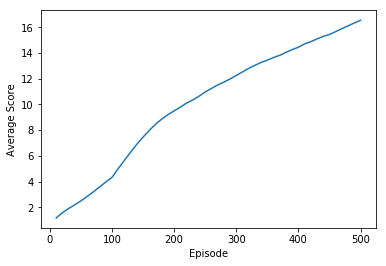

In [18]:
config = {}
config['env'] = env
config['print_every'] = 25
config['plot_every'] = 10
config['episodes'] = 500
agent = Agent(config)
env_utils.run(agent)
torch.save(agent.policy.state_dict(), 'checkpoints/PPO-1.pth')

In [11]:
config = {}
config['env'] = env
config['train_mode'] = False
agent = Agent(config)
checkpoint = torch.load('checkpoints/PPO-1.pth')
agent.policy.load_state_dict(checkpoint)
env_utils.run(agent)

<img src="img/PPO-1.gif" />